#**Three Categories**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from google.colab import files
import pickle

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# Other constants
model_save_name = 'resnet_3_categories_model.pth'
statistic_save_name = 'resnet_3_categories_statistic.pkl'
statistic_path = F"/content/drive/My Drive/comp6721-project/{statistic_save_name}"
model_path = F"/content/drive/My Drive/comp6721-project/{model_save_name}" 

ROOT_PATH = '/content/drive/MyDrive/comp6721-project/datasets/dataset-3/'
training_path = f'{ROOT_PATH}/train'
validation_path = f'{ROOT_PATH}/val'
evaluation_path = f'{ROOT_PATH}/test'

# Model training constants
batch_size = 32
num_epochs = 15

# Loss function & optimizer constants
lr = 0.0001

# Image constants
image_size = 256
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
num_classes = 3

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


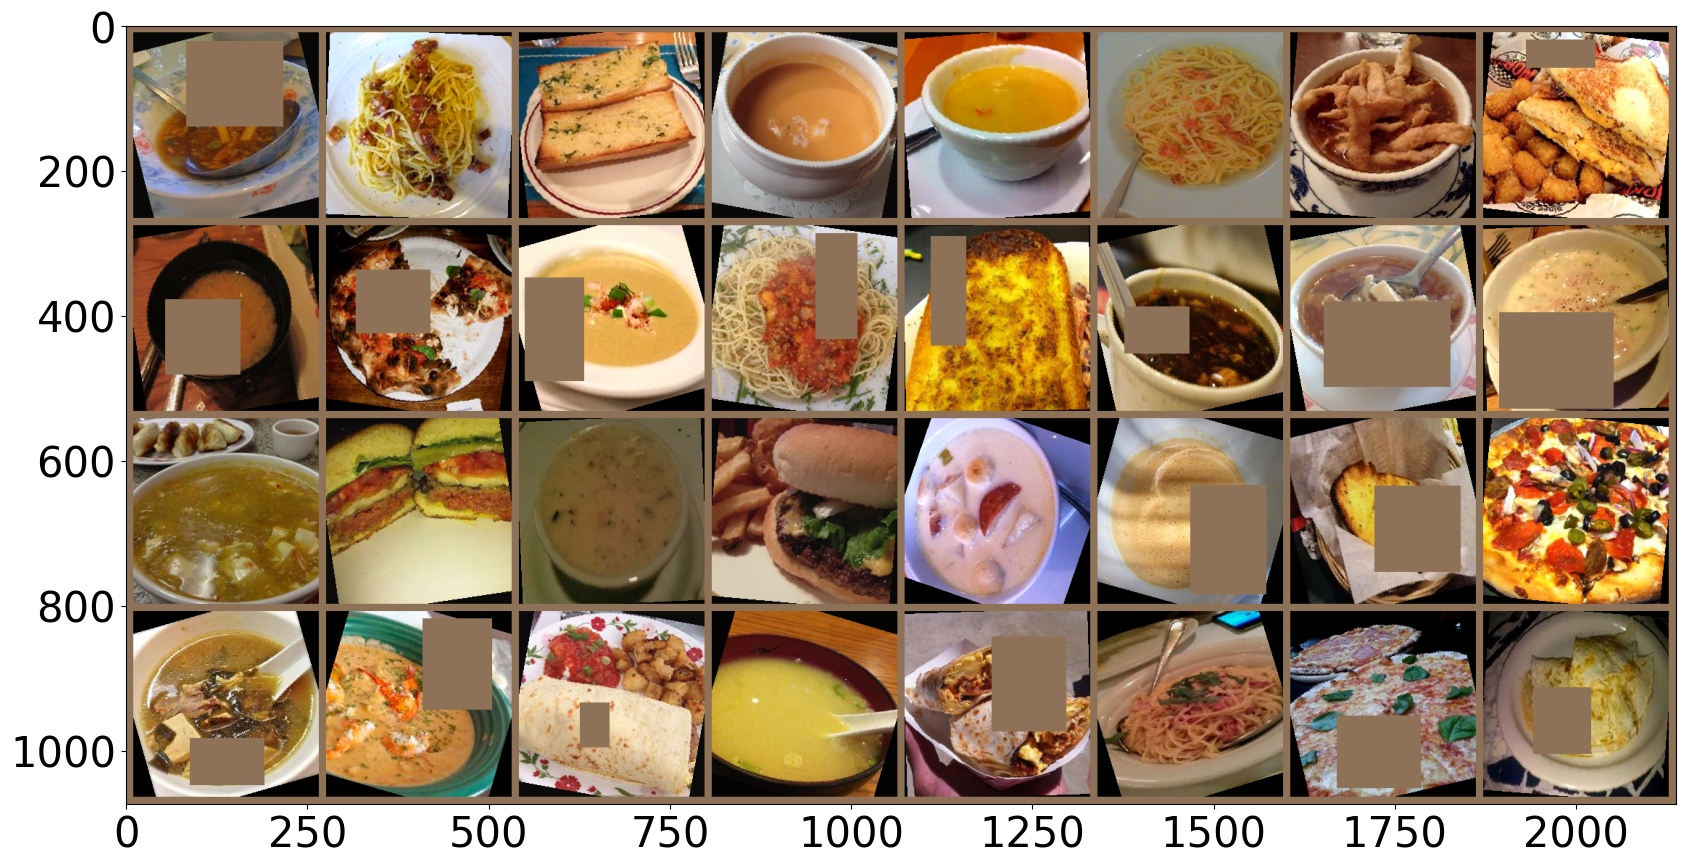

In [ ]:
# Transform
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, num_classes, device)
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Dataset
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)
validation_dataset = datasets.ImageFolder(validation_path, transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

# Image samples
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Training

In [ ]:
# Training
%%time

accuracy = []
valid_accuracy = []
step_accuracy_total = []
step_accuracy_validation_total = []
step_loss_total = []
loss = []
total_steps = len(train_dataloader)


for epoch in range(num_epochs):
    step_acc = []
    step_loss = []
    for i , (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss_v = criterion(outputs, labels)
        
        #backward
        optimizer.zero_grad()
        loss_v.backward()
        
        #update parameters
        optimizer.step()
        
        #train accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        step_acc.append((correct / total) * 100)
        step_loss.append(loss_v.item())
        if (i + 1) % 30 == 0:
            step_accuracy_total.append((correct / total) * 100)
            step_loss_total.append(loss_v.item())
            correct_v = 0
            total_v = 0
            for dataVal in validation_dataloader:
                images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                outputs = model(images_v)
                _, predicted = torch.max(outputs.data, 1)
                correct_v += (predicted == labels_v).sum().item()
                total_v += labels_v.size(0) 
            step_accuracy_validation_total.append((correct_v / total_v) * 100)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_steps, loss_v.item(),(correct / total) * 100,(correct_v / total_v) * 100))     
      
    correct_v = 0
    total_v = 0
    for dataVal in validation_dataloader:
        images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
        outputs = model(images_v)
        _, predicted = torch.max(outputs.data, 1)
        correct_v += (predicted == labels_v).sum().item()
        total_v += labels_v.size(0)        
    accuracy.append(sum(step_acc)/len(step_acc))
    valid_accuracy.append((correct_v / total_v) * 100)
    loss.append(sum(step_loss)/len(step_loss))



Epoch [1/15], Step [30/75], Loss: 0.7344, Accuracy: 65.62%, Validation Accuracy: 42.96%
Epoch [1/15], Step [60/75], Loss: 0.6969, Accuracy: 75.00%, Validation Accuracy: 46.05%
Epoch [2/15], Step [30/75], Loss: 0.5528, Accuracy: 68.75%, Validation Accuracy: 43.64%
Epoch [2/15], Step [60/75], Loss: 0.7808, Accuracy: 68.75%, Validation Accuracy: 46.39%
Epoch [3/15], Step [30/75], Loss: 0.4651, Accuracy: 78.12%, Validation Accuracy: 48.45%
Epoch [3/15], Step [60/75], Loss: 0.4527, Accuracy: 84.38%, Validation Accuracy: 47.42%
Epoch [4/15], Step [30/75], Loss: 0.4083, Accuracy: 81.25%, Validation Accuracy: 46.05%
Epoch [4/15], Step [60/75], Loss: 0.5292, Accuracy: 75.00%, Validation Accuracy: 47.77%
Epoch [5/15], Step [30/75], Loss: 0.7893, Accuracy: 65.62%, Validation Accuracy: 51.20%
Epoch [5/15], Step [60/75], Loss: 0.4324, Accuracy: 84.38%, Validation Accuracy: 45.70%
Epoch [6/15], Step [30/75], Loss: 0.4304, Accuracy: 81.25%, Validation Accuracy: 47.42%
Epoch [6/15], Step [60/75], Loss

## Save model

In [ ]:
torch.save(model.state_dict(), model_path)

with open(statistic_path, 'wb') as f:
    data = {
        'train_acc': accuracy,
        'train_acc_valid': valid_accuracy,
        'train_loss': loss,
        'train_acc_step': step_accuracy_total,
        'train_acc_valid_step': step_accuracy_validation_total,
        'train_loss_step': step_loss_total,
    }
    pickle.dump(data, f)

## Valuation

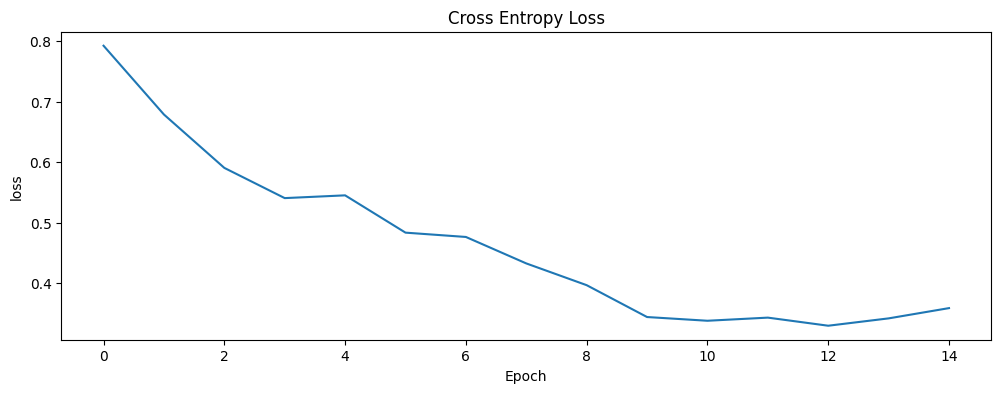

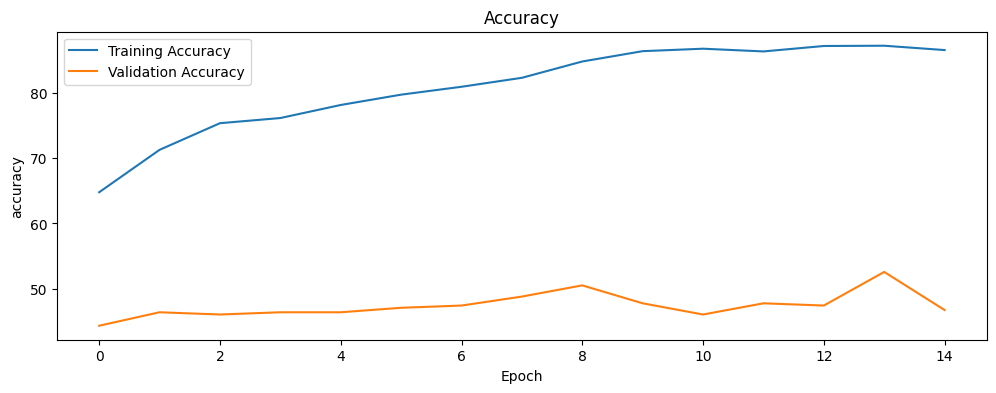

Train accuracy: 90.56
Test accuracy: 85.24
Confusion Matrix:
[[ 93   2   5]
 [  8  29   2]
 [ 10  13 109]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       100
           1       0.66      0.74      0.70        39
           2       0.94      0.83      0.88       132

    accuracy                           0.85       271
   macro avg       0.81      0.83      0.82       271
weighted avg       0.86      0.85      0.85       271



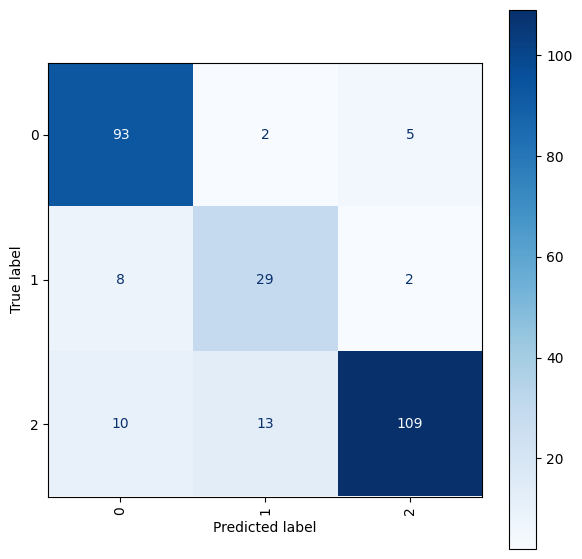

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


plt.figure(figsize=(12, 4))
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(accuracy, label="Training Accuracy")
plt.plot(valid_accuracy, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)
        fig, ax = plt.subplots(figsize=(7, 7))
        ConfusionMatrixDisplay(cm).plot(ax=ax,cmap='Blues', xticks_rotation='vertical', values_format='d')
        plt.show()  


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)

## t-SNE

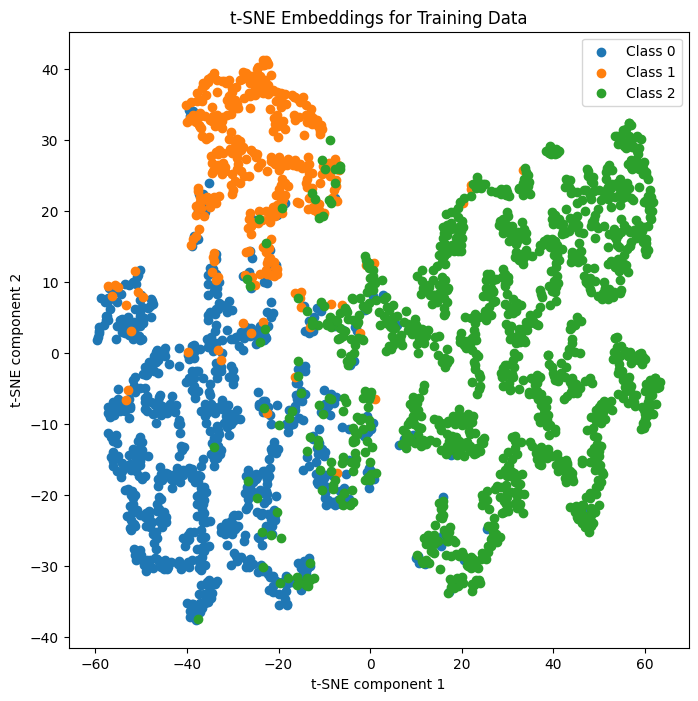

CPU times: user 19.9 s, sys: 864 ms, total: 20.8 s
Wall time: 33.3 s


In [ ]:
%%time

def compute_tsne(model, dataloader):
    """
    Computes t-SNE embeddings for the given model and dataloader.
    """
    # Set model to evaluation mode
    model.eval()
        
    # Get the features from the last layer for all samples in the dataset
    features = []
    labels = []

    # Define a function to extract the features from the last layer
    # def get_features_hook(module, input, output):
    #     features.append(output.detach().cpu().numpy())

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # model.fc.register_forward_hook(get_features_hook)
            outputs = model(inputs)
            features.append(outputs.detach().cpu().numpy())
            labels.append(targets.detach().cpu().numpy())
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embeddings = tsne.fit_transform(features)

    return embeddings, labels


train_embeddings, train_labels = compute_tsne(model, train_dataloader)
# Plot t-SNE embeddings for the training datasets
import matplotlib.pyplot as plt

# Plot t-SNE embeddings
plt.figure(figsize=(8,8))
for i in range(num_classes):
    plt.scatter(train_embeddings[train_labels==i,0], train_embeddings[train_labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

# Helper Funtion 

**not part of the experiment**

In [ ]:
# Load model
from google.colab import files

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

{'train_acc': [64.79166666666667, 71.29166666666667, 75.375, 76.16666666666667, 78.16666666666667, 79.75, 80.95833333333333, 82.33333333333333, 84.83333333333333, 86.41666666666667, 86.79166666666667, 86.375, 87.20833333333333, 87.25, 86.58333333333333], 'train_acc_valid': [44.329896907216494, 46.391752577319586, 46.04810996563574, 46.391752577319586, 46.391752577319586, 47.07903780068728, 47.42268041237113, 48.797250859106526, 50.51546391752577, 47.766323024054984, 46.04810996563574, 47.766323024054984, 47.42268041237113, 52.57731958762887, 46.735395189003434], 'train_loss': [0.7923526318868002, 0.678634983698527, 0.590393887758255, 0.5404412893454233, 0.5450006874402364, 0.48335301319758095, 0.4762128553787867, 0.4324697615702947, 0.3965103715658188, 0.3438491860032082, 0.33769360939661663, 0.3428686398267746, 0.32948315302530923, 0.3416242951154709, 0.35859660198291143], 'train_acc_step': [65.625, 75.0, 68.75, 68.75, 78.125, 84.375, 81.25, 75.0, 65.625, 84.375, 81.25, 81.25, 78.125,

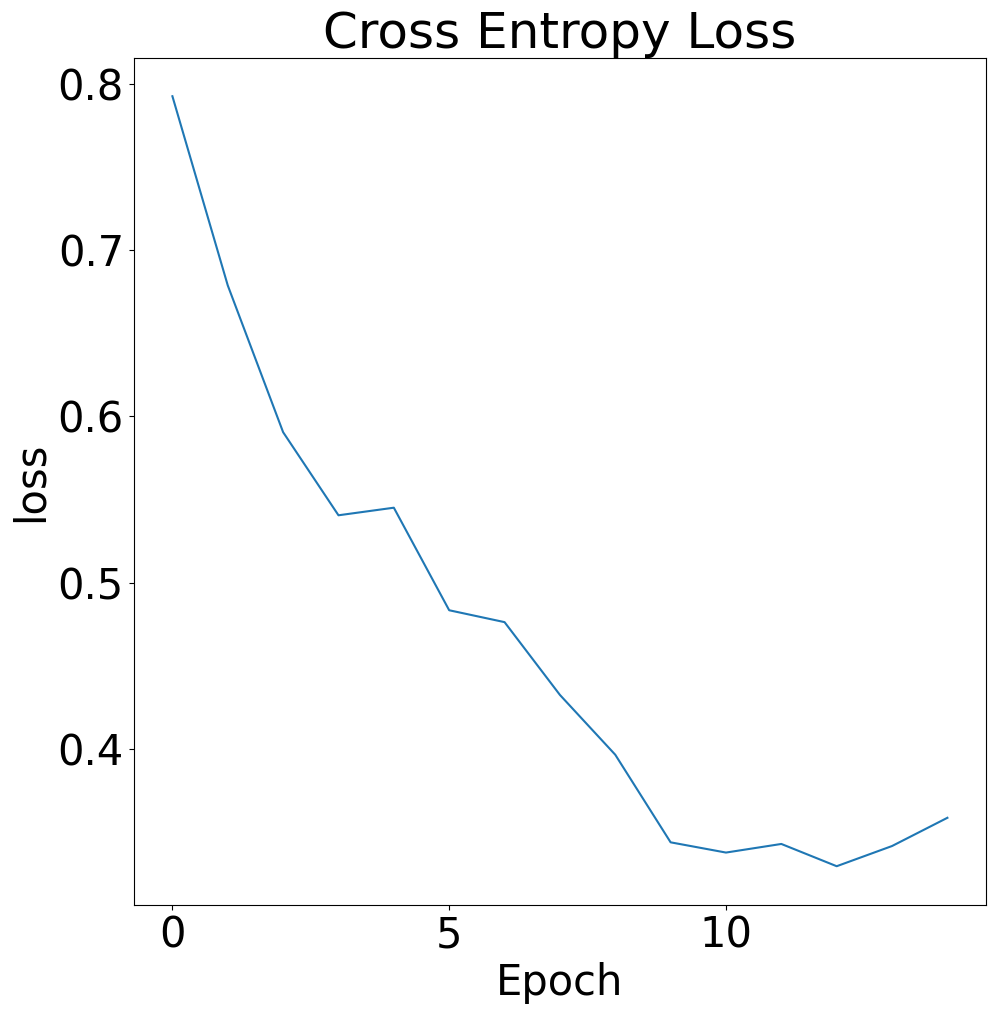

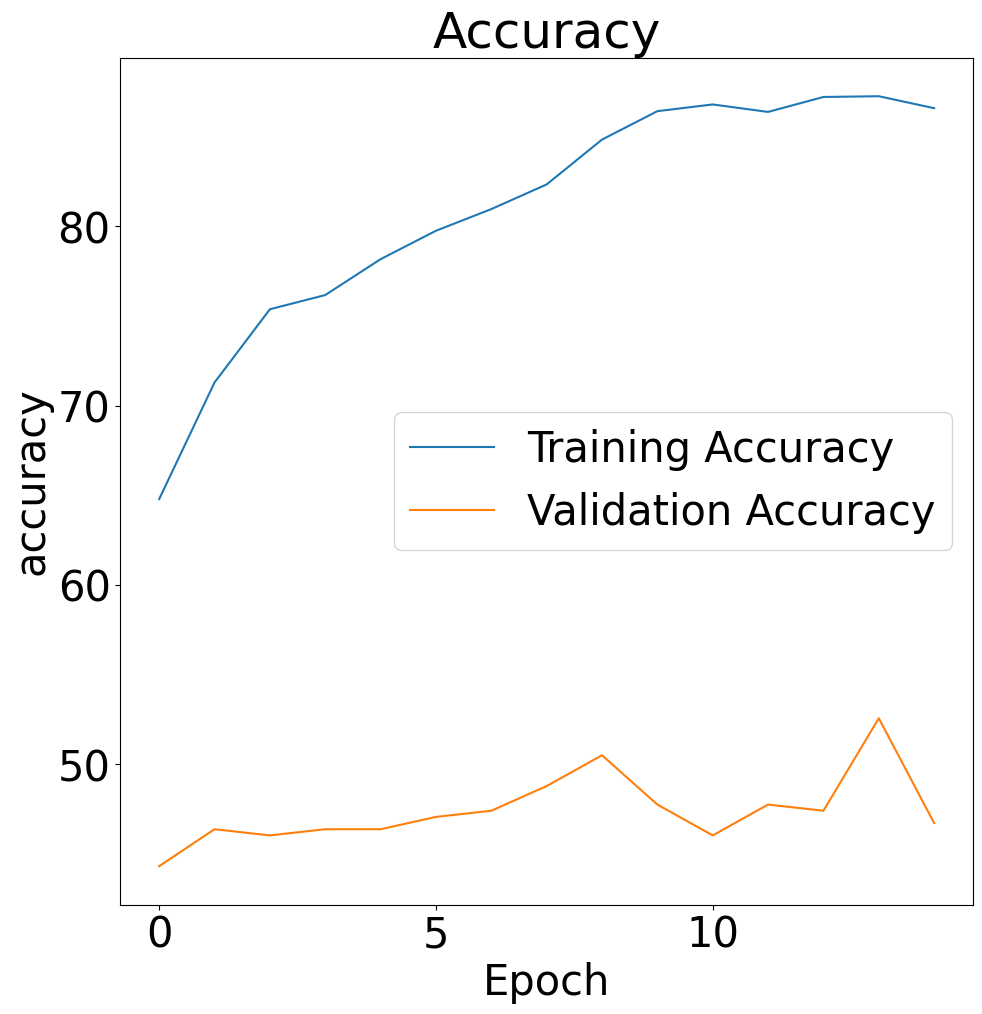

In [ ]:
# Load the experiment data from file and plot for report

with open(statistic_path, 'rb') as f:
    data = pickle.load(f)
    print(data)
    train_acc = data['train_acc']
    train_acc_valid = data['train_acc_valid']
    train_loss = data['train_loss']
    train_acc_step = data['train_acc_step']
    train_acc_valid_step = data['train_acc_valid_step']
    train_loss_step = data['train_loss_step']

plt.rcParams['font.size'] = '30'

plt.figure(figsize=(11, 11))
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(11, 11))
plt.plot(train_acc, label="Training Accuracy")
plt.plot(train_acc_valid, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


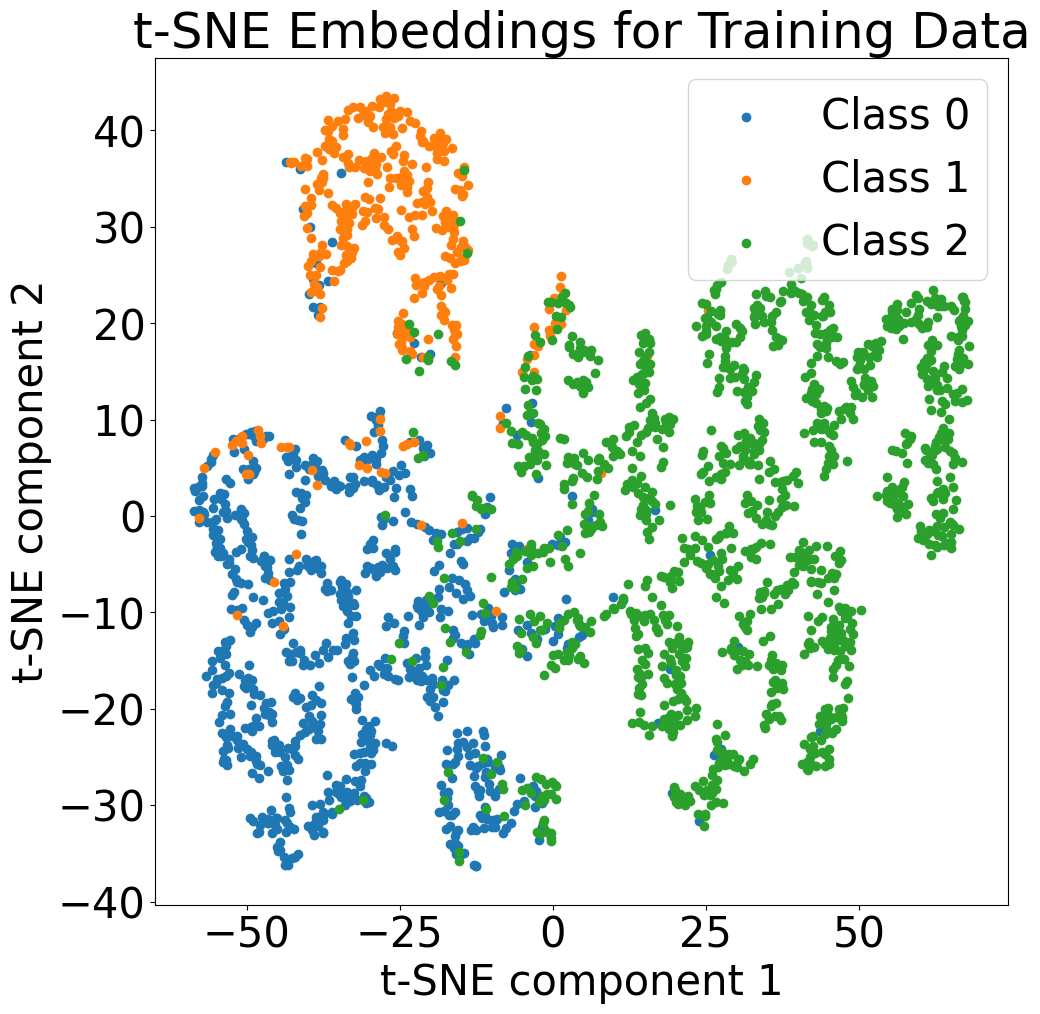

In [ ]:
def compute_tsne(model, dataloader):
    """
    Computes t-SNE embeddings for the given model and dataloader.
    """
    # Set model to evaluation mode
    model.eval()
        
    # Get the features from the last layer for all samples in the dataset
    features = []
    labels = []

    # Define a function to extract the features from the last layer
    # def get_features_hook(module, input, output):
    #     features.append(output.detach().cpu().numpy())

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # model.fc.register_forward_hook(get_features_hook)
            outputs = model(inputs)
            features.append(outputs.detach().cpu().numpy())
            labels.append(targets.detach().cpu().numpy())
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embeddings = tsne.fit_transform(features)

    return embeddings, labels


train_embeddings, train_labels = compute_tsne(model, train_dataloader)
# Plot t-SNE embeddings for the training datasets
import matplotlib.pyplot as plt

# Plot t-SNE embeddings
plt.figure(figsize=(11,11))
for i in range(num_classes):
    plt.scatter(train_embeddings[train_labels==i,0], train_embeddings[train_labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()